In [41]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.4/294.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 10.2 MB/s eta 0:00:00


In [14]:
# First step is always import the necessary packages
import psycopg2
import psycopg2.extras
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# Connect to the database
connection = psycopg2.connect(host='localhost',
                             user='paygapuser',
                          port=5432,
                             database='paygap',
                             password='')
connection.set_session(readonly=True, autocommit=True)

#From our connection we need a cursor, which acts as our interface into the database
cur = connection.cursor(cursor_factory = psycopg2.extras.RealDictCursor)

In [3]:
#From a cursor we can execute SQL directly
res = cur.execute("Select * From paygap.text LIMIT 5")
print(f"When executing a cursor, we don't get back any value: {res}")

When executing a cursor, we don't get back any value: None


In [4]:
cur.execute("SELECT count(*) FROM paygap.text;")
res = cur.fetchone()

In [5]:
res

RealDictRow([('count', 687120)])

## Words in a tweet

Get the word_count for each tweet.

In [ ]:
query = """
SELECT conversation_id, text, 
    (SELECT COUNT(*) FROM regexp_split_to_table(text, E'\\s+')) AS word_count
FROM paygap.text;
"""

cur.execute(query)
words = cur.fetchall()

df_words = pd.DataFrame.from_dict(words)
df_words.sample(10)

,conversation_id,text,word_count
242891,1484049520581353473,RT @RepValDemings: Not everyone has the abilit...,6
120475,1486140317795557378,RT @cenkuygur: Show me one poll where the vote...,5
376822,1482190179657998339,The fact that so many Republicans are rolling ...,13
577800,1479137937082265609,@k_n_o_w_b_0_d_y @HanekawaSenpai @ChristinaTas...,15
334467,1482965578503524354,RT @incorrectaegyu: beomgyu: taehyun and i sha...,6
323221,1482759887641841672,@LakeHouseLife2 @Meidas_Jules I’m not a Democr...,6
226786,1484242310447525888,RT @space_mom_: When We Were Young Fest looked...,6
656025,1477857587177705475,RT @Jusrangers: All of society can get back to...,9
520226,1480174236199272448,RT @CllrJonSHarvey: Currently the National Blo...,6
678961,1477360889208705024,So many hot takes on what ppl should be doing ...,13


Alter the table to have only tweets with more than 3 words.

ALTER TABLE paygap.text ADD COLUMN word_count INTEGER;
UPDATE paygap.text SET word_count = (SELECT COUNT(*) FROM regexp_split_to_table(text_column, E'\\s+') AS words);

Query executed in DBEAVER.

### Location Data

In [6]:
query = """
select count(distinct location) as nos FROM paygap.users;
"""

cur.execut(query)
location = cur.fetchone()

print(f'There are {location["nos"]} distinct user defined locations in our database')

There are 112487 distinct user defined locations in our database


In [18]:
query = """
select distinct location from paygap.users limit 20;
"""

cur.execute(query)
locations = cur.fetchall()

df_loc = pd.DataFrame.from_dict(locations)
df_loc

,location
0,ETH
1,"East London, United Kingdom"
2,hugging a tree 🇬🇧
3,all + kaeya enjoyer
4,London and Dubai
5,a Georgia piedmont cul-de-sac
6,Studio
7,"Macungie, PA"
8,The Minds Eye.
9,West of Ireland.


### Language

In [8]:
query = """
select count(distinct lang) as lan from paygap.notext;
"""

cur.execute(query)
language = cur.fetchone()

print(f'There are {language["lan"]} distinct languages in our database')

There are 60 distinct languages in our database


In [9]:
query = """
select lang, count(conversation_id) as no_tweets from paygap.notext 
group by lang order by no_tweets desc;
"""

cur.execute(query)
languages = cur.fetchall()

df_lang = pd.DataFrame.from_dict(languages)
df_lang

,lang,no_tweets
0,en,755159
1,hi,3723
2,tl,2053
3,qme,1601
4,zxx,1140
5,ko,1095
6,de,943
7,es,875
8,ja,624
9,und,597


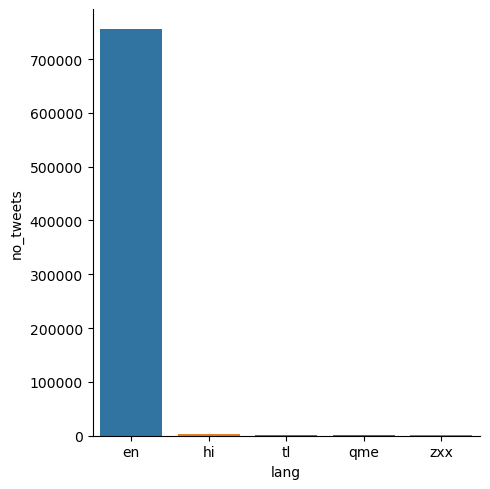

In [11]:
sns.catplot(data=df_lang.nlargest(5, 'no_tweets'), 
            x="lang", y="no_tweets", kind="bar")

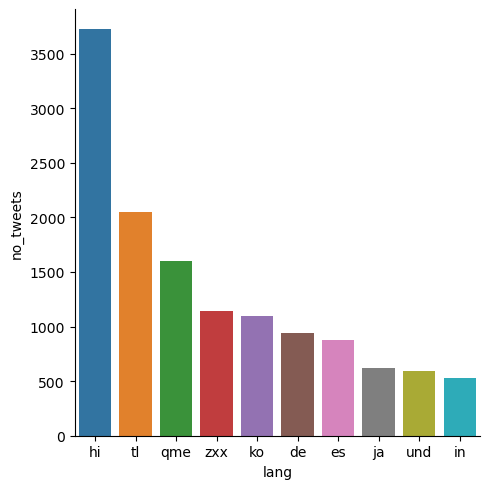

In [15]:
df_no_eng = df_lang.iloc[1:, :]
sns.catplot(data=df_no_eng.nlargest(10, 'no_tweets'), 
            x="lang", y="no_tweets", kind="bar")

The top 5 languages apart from english are:   
Hindi  
Tagalog  
Korean  
German  
Spanish  

The codes qme and zxx are not languages but are codes for tweets with only pictures and language not applicable.

### Verified Vs Unverified Users

In [28]:
def verified_vs_non():
    

    query_1 = """
    select count(*) as veri from paygap.users where verified = 'true';
    """

    query_2 = """
    select count(verified) as non_ver from paygap.users where verified = 'false';
    """

    cur.execute(query_1)
    check_1 = cur.fetchone()

    cur.execute(query_2)
    check_2 = cur.fetchone()
    
    return check_1, check_2

verified_vs_non()

print(f'There are {check_1["veri"]} verified in our database')
print(f'There are {check_2["non_ver"]} nonverified users in our database')

There are 132040 verified in our database
There are 724130 nonverified users in our database


## Tweets Table

In [43]:
tweets_df = pd.read_sql('''SELECT distinct t.text, t.author_id, t.conversation_id, 
	n.like_count, n.quote_count, n.retweet_count
	FROM paygap.text t 
	JOIN paygap.notext n
	On t.conversation_id = n.conversation_id
		and t.author_id = n.author_id
    Where lang = 'en'
        and word_count > 3;''',connection)
tweets_df

/var/folders/2b/49hmp8_d5vn9djtxvv78l7sh0000gn/T/ipykernel_22524/2749562412.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tweets_df = pd.read_sql('''SELECT distinct t.text, t.author_id, t.conversation_id,


,text,author_id,conversation_id,like_count,quote_count,retweet_count
0,!!! \nYou have to get it out. https://t.co/wAA...,1483235218408550404,1483352622467850241,0,1,0
1,"!!!! ""I’m confident we can get pieces, big chu...",25702314,1483913398899380235,29,2,6
2,""" #Bitcoin does not equal blockchain, the trem...",772963418072555522,1484350672031997958,1,0,0
3,""" .. mandating that NYC employers w/ 4 or more...",1229675046,1480493475284099072,1,0,0
4,""" @HRC 's survey of 7,000 full-time workers fo...",77834136,1483835893848977409,2,0,2
...,...,...,...,...,...,...
567468,🧵There are 4 factors that can be addressed if ...,1356936103853514752,1482323822141390852,40,3,18
567469,"🧵Today, Elizabeth Fry EDs from across the coun...",340952679,1481346054377426953,22,0,4
567470,🧵Yep. No shortage of roadmaps and plans. What...,1394759320496218112,1478434617875173376,22,0,8
567471,🧵🧵🧵: Tons of respect for Coach Pees and his pl...,255939663,1479328428713132032,17,1,2


In [44]:
tweets_df['text'].nunique()

220138

### Prep for Feature Extraction

In [45]:
# remove punctuations
import string
import re 
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

def remove_acc(text):
    '''
    Removes all accented characters from a string, if present 
    Args:
        text (str): String to which the function is to be applied, string 
    Returns:
        Clean string without accented characters
    '''
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

#tokenzing
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

# remove stop words - return a list of the remaining words
stopword = nltk.corpus.stopwords.words('english')
stopword = stopword + ['rt', 'RT']

def remove_stopwrods (tokenized_list):
  text = [word for word in tokenized_list if word not in stopword]
  return text 

## Lemmatizing 
wn = nltk.WordNetLemmatizer()
def lemmatizing (tokenized_text):
  text = " ".join ([wn.lemmatize(word) for word in tokenized_text])
  return text

In [46]:
def prep_text():
    
    #remove url
    tweets_df['text'] = tweets_df['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

    #remove links
    tweets_df['text'] = tweets_df['text'].apply(lambda x: remove_punct(x))
    
    #remove accented char
    tweets_df['text'] = tweets_df['text'].apply(lambda x: remove_acc(x))
    
    #tokenize
    tweets_df['text'] = tweets_df['text'].apply(lambda x: tokenize(x.lower()))
    
    #stopwords
    tweets_df ['text'] = tweets_df['text'].apply(lambda x: remove_stopwrods (x))
    
    #Lemmatizing
    tweets_df ['text'] = tweets_df ['text'].apply (lambda x: lemmatizing (x))
    
    return tweets_df

prep_text()

,text,author_id,conversation_id,like_count,quote_count,retweet_count
0,get,1483235218408550404,1483352622467850241,0,1,0
1,im confident get piece big chunk build back b...,25702314,1483913398899380235,29,2,6
2,bitcoin equal blockchain tremendous promise b...,772963418072555522,1484350672031997958,1,0,0
3,mandating nyc employer w 4 employee incorpora...,1229675046,1480493475284099072,1,0,0
4,hrc survey 7000 fulltime worker found median ...,77834136,1483835893848977409,2,0,2
...,...,...,...,...,...,...
567468,4 factor addressed watershed moment cultural l...,1356936103853514752,1482323822141390852,40,3,18
567469,today elizabeth fry ed across country opportun...,340952679,1481346054377426953,22,0,4
567470,yep shortage roadmaps plan could holding 10dow...,1394759320496218112,1478434617875173376,22,0,8
567471,ton respect coach pee plight he right lot you...,255939663,1479328428713132032,17,1,2


In [49]:
tweets_lda = tweets_df.drop_duplicates('text')
tweets_lda

,text,author_id,conversation_id,like_count,quote_count,retweet_count
0,get,1483235218408550404,1483352622467850241,0,1,0
1,im confident get piece big chunk build back b...,25702314,1483913398899380235,29,2,6
2,bitcoin equal blockchain tremendous promise b...,772963418072555522,1484350672031997958,1,0,0
3,mandating nyc employer w 4 employee incorpora...,1229675046,1480493475284099072,1,0,0
4,hrc survey 7000 fulltime worker found median ...,77834136,1483835893848977409,2,0,2
...,...,...,...,...,...,...
567468,4 factor addressed watershed moment cultural l...,1356936103853514752,1482323822141390852,40,3,18
567469,today elizabeth fry ed across country opportun...,340952679,1481346054377426953,22,0,4
567470,yep shortage roadmaps plan could holding 10dow...,1394759320496218112,1478434617875173376,22,0,8
567471,ton respect coach pee plight he right lot you...,255939663,1479328428713132032,17,1,2


In [50]:
tweets_lda['text'].nunique()

214431

### TF-IDF

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_vect = TfidfVectorizer(max_features=23482)
sample_tweet = tweets_lda['text'].sample(n=50000, random_state=42)
Tfidf_vect.fit(sample_tweet)

x_tfidf_ngram = pd.DataFrame (Tfidf_vect.fit_transform (sample_tweet).toarray())
print (x_tfidf_ngram.shape)
print (Tfidf_vect.get_feature_names_out())
x_tfidf_ngram.columns = Tfidf_vect.get_feature_names_out()
feature_tfidf = Tfidf_vect.get_feature_names_out()
x_tfidf_ngram.head(100)

(50000, 23482)
['000' '001' '005' ... 'zulu' 'zuma' 'zygotea']


,000,001,005,01,010,01012016,016,01ivi3r1u6,02,04,...,zombie,zone,zoo,zoom,zooming,zsk,zubymusic,zulu,zuma,zygotea
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
#define the lda function, with desired options
lda = LatentDirichletAllocation(n_components=3, max_iter=20,
                                learning_method='online',
                                learning_offset=80.,
                                random_state=0)
#fit the model
lda.fit(x_tfidf_ngram)

LatentDirichletAllocation(learning_method='online', learning_offset=80.0,
                          max_iter=20, n_components=3, random_state=0)

In [57]:
topic_dist = lda.transform(x_tfidf_ngram)
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(tweets_lda)
df_w_topics

,0,1,2,text,author_id,conversation_id,like_count,quote_count,retweet_count
0,0.059897,0.787125,0.152978,get,1.483235e+18,1.483353e+18,0.0,1.0,0.0
1,0.067501,0.559196,0.373303,im confident get piece big chunk build back b...,2.570231e+07,1.483913e+18,29.0,2.0,6.0
2,0.056909,0.882504,0.060587,bitcoin equal blockchain tremendous promise b...,7.729634e+17,1.484351e+18,1.0,0.0,0.0
3,0.059649,0.881009,0.059343,mandating nyc employer w 4 employee incorpora...,1.229675e+09,1.480493e+18,1.0,0.0,0.0
4,0.061549,0.564302,0.374148,hrc survey 7000 fulltime worker found median ...,7.783414e+07,1.483836e+18,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...
49995,0.287325,0.260987,0.451688,mulletsimp drmc0628 dominicptaranto miaana14 a...,8.153499e+17,1.483132e+18,1.0,0.0,0.0
49996,0.062404,0.875651,0.061944,mullin95 rhofford pound manipulate come join 2...,5.259280e+08,1.483894e+18,2.0,0.0,0.0
49997,0.068238,0.815423,0.116338,mullingmueller brittnymejia delwilber rightly ...,7.265688e+07,1.483465e+18,6.0,0.0,0.0
49998,0.075415,0.615525,0.309061,mulslip seaburnstweet papigolf mysportsupdate ...,2.463744e+09,1.479074e+18,0.0,0.0,0.0


https://notebook.community/lknelson/text-analysis-2017/05-TextExploration/00-IntroductionToTopicModeling_ExerciseSolutions

https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6

In [58]:
# Show top n keywords for each topic
def show_topics(vectorizer=Tfidf_vect, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=Tfidf_vect, lda_model=lda, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,security,equal,earns,india,university,police,visit,trump,sir,pay,work,harry,president,spot,talent
Topic 1,pay,leave,paid,get,people,dont,work,like,time,would,sick,one,im,want,need
Topic 2,woman,gap,men,earn,gender,day,game,player,international,2022,wage,team,watch,amp,equal


In [59]:
print_top_words(lda, feature_tfidf, 5)


Topic #0:
security equal earns india university

Topic #1:
pay leave paid get people

Topic #2:
woman gap men earn gender



Overall, the topics that standout are:  
1. Pay security and policy   
2. Sick leave and Paid Leave  
3. Wage gap in 2022  

In [63]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_w_topics[[0,1,2]].values, axis=1)
df_w_topics['dominant_topic'] = dominant_topic

In [79]:
df_w_topics.loc[df_w_topics['dominant_topic'] == 0, 'dominant_topic'] = 'Pay Security and Policy'
df_w_topics.loc[df_w_topics['dominant_topic'] == 1, 'dominant_topic'] = 'Paid Sick Leave'
df_w_topics.loc[df_w_topics['dominant_topic'] == 2, 'dominant_topic'] = 'Wage Gap in 2022'

In [80]:
df_topic = df_w_topics[['text', 'dominant_topic',
                        'like_count', 'quote_count', 'retweet_count']]
df_topic

,text,dominant_topic,like_count,quote_count,retweet_count
0,get,Paid Sick Leave,0.0,1.0,0.0
1,im confident get piece big chunk build back b...,Paid Sick Leave,29.0,2.0,6.0
2,bitcoin equal blockchain tremendous promise b...,Paid Sick Leave,1.0,0.0,0.0
3,mandating nyc employer w 4 employee incorpora...,Paid Sick Leave,1.0,0.0,0.0
4,hrc survey 7000 fulltime worker found median ...,Paid Sick Leave,2.0,0.0,2.0
...,...,...,...,...,...
49995,mulletsimp drmc0628 dominicptaranto miaana14 a...,Wage Gap in 2022,1.0,0.0,0.0
49996,mullin95 rhofford pound manipulate come join 2...,Paid Sick Leave,2.0,0.0,0.0
49997,mullingmueller brittnymejia delwilber rightly ...,Paid Sick Leave,6.0,0.0,0.0
49998,mulslip seaburnstweet papigolf mysportsupdate ...,Paid Sick Leave,0.0,0.0,0.0


In [81]:
df_topic.to_csv('topic.csv')